In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import sys

## Reading and Plotting images given

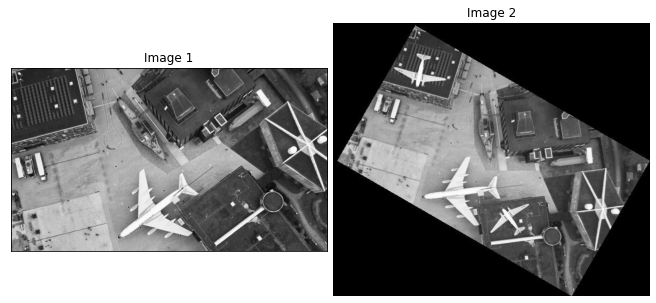

In [2]:
img1 = imageio.imread("IMG1.png")
img2 = imageio.imread("IMG2.png")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,12), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.imshow(img1, 'gray')
ax2.imshow(img2, 'gray')
ax1.title.set_text('Image 1')
ax2.title.set_text('Image 2')
plt.axis('off')
plt.show()

## Point Correspondences and Computing Homography
The given problem has in-plane rotation and in-plane translation in context. The Homography can be written as
\begin{gather}
H =
\begin{bmatrix}
sin (\theta) & cos (\theta) & T_x\\
cos (\theta) & -sin (\theta) & T_y\\
0 & 0 & 1
\end{bmatrix}
\end{gather}

H holds only up to a scale factor. The homography can be rewritten as
\begin{gather}
H =
\begin{bmatrix}
ksin (\theta) & kcos (\theta) & kT_x\\
kcos (\theta) & -ksin (\theta) & kT_y\\
0 & 0 & k
\end{bmatrix}
=
\begin{bmatrix}
s_t & c_t & t_x\\
c_t & -s_t & t_y\\
0 & 0 & h
\end{bmatrix}
\end{gather}

We have 5 unknown variables and two point correspondances, ie., a point x,y maps to x',y'. The same can be written as
\begin{gather}
x' &= \frac{s_tx + c_ty + t_x}{h} x \\
y' &= \frac{c_tx - s_ty + t_y}{h} y
\end{gather}

This can be written in the matrix format as 
\begin{gather}
Ah' &=  0
\end{gather}

where
\begin{gather}
A =
\begin{bmatrix}
x & y & 1 & 0 & -x' \\
y & -x & 0 & 1 & -y'
\end{bmatrix}
\end{gather}
and
\begin{gather}
h' = [s_t & c_t & t_x & t_y & h]^T
\end{gather}

For the 2 point correspondences we now have A as a 4x5 matrix. To obtain $ ||Ah||^2 $ as small as possible, we perform SVD and take the last column of $V^T$ to be h. The 5 random variables can be rearranged in the H matrix to get the homography. 

In [3]:
pointsinimg1 = np.array([(29,124),(157,372)])
pointsinimg2 = np.array([(93,248),(328,399)])
# The corresponding points as given
pointcorrespondances = len(pointsinimg1)
# no. of two correspondances
A = np.zeros((2*pointcorrespondances,5))
# compute A matrix
for i in range(pointcorrespondances):
    x,y = pointsinimg2[i]
    u,v = pointsinimg1[i]
    A[2*i] = [x, y, 1, 0, -u]
    A[2*i+1] = [y, -x, 0, 1, -v]
U, S, V_transpose = np.linalg.svd(A)
# perform SVD and get h
a, b, c, d, h = V_transpose[-1]
H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)
# obtain homography

## Related Functions
The following functions perform this
1. Corresponding points mapping: perform homography and return non-homogenous coordinates of transformed image 2
2. Floor function: mathematical floor function
3. Binary Interpolation

In [4]:
def corresponding_points_mapping(H, X1):
    X2 = H@X1
    # X1 is homogenous coordinates from image 1
    if X2[-1]!=0:
        # return in non homogenous coordinates
        return X2[0]/X2[-1], X2[1]/X2[-1]

In [5]:
def floor(value):
    if value >= 0:
        return int(value)
    else:
        return int(value)-1
    # floor operation

In [6]:
def bilinear_interpolate(image, x, y):
    # The input image has to be zero padded before the function is called
    # Get image dimensions dx, dy
    dx, dy = np.shape(image)
    # get the shape of the original image
    dx, dy = dx-2, dy-2
    # Add 1 to xs and ys to correct for zero padding
    x, y = x+1, y+1

    # x', y', a, b as defined in the lecture
    xx, yy = floor(x), floor(y)
    a = x-xx
    b = y-yy

    if xx >= 0 and xx <= dx and yy >= 0 and yy <= dy:
        intensity = (1-a)*(1-b)*image[xx, yy] \
            + (1-a)*b*image[xx, yy+1] \
            + a*(1-b)*image[xx+1, yy] \
            + a*b*image[xx+1, yy+1]
    else:
        intensity = 0

    return intensity

## Transform Image 2

In [7]:
x, y = np.shape(img2)
image = np.zeros((x+2, y+2))
image[1:-1, 1:-1] = img2
H_inv = np.linalg.inv(H)
target_image = np.zeros((x, y))
for xt in range(x):
    for yt in range(y):
        hom_coords_target = np.array([xt, yt, 1])
        xs, ys = corresponding_points_mapping(H_inv, hom_coords_target)
        val = bilinear_interpolate(image, xs, ys)
        target_image[xt, yt] = val

## Plot output of homography

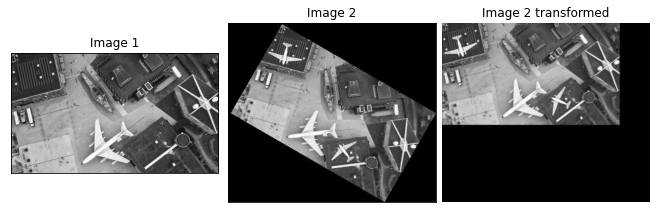

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,12), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax1.imshow(img1, 'gray')
ax2.imshow(img2, 'gray')
ax3.imshow(target_image, 'gray')
ax1.title.set_text('Image 1')
ax2.title.set_text('Image 2')
ax3.title.set_text('Image 2 transformed')
plt.axis('off')
plt.show()

We observe that the image after applying homography has empty pixels. We crop the image to the first image's coordinates.

In [9]:
x1, y1 = np.shape(img1)
img2_transformed = target_image[:x1, :y1]

## Plot difference of images

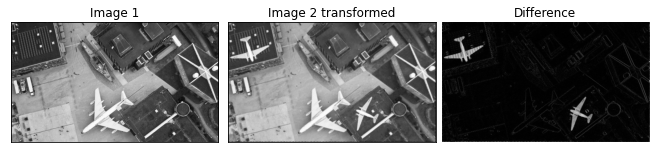

In [10]:
#To ensure we have positive values only
diff = abs(img1-img2_transformed)
# Normalizing the difference image to lie between 0 and 1 
diff = diff/np.max(diff)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,12), constrained_layout=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax1.imshow(img1, 'gray')
ax2.imshow(img2_transformed, 'gray')
ax3.imshow(diff, 'gray')
ax1.title.set_text('Image 1')
ax2.title.set_text('Image 2 transformed')
ax3.title.set_text('Difference')
plt.axis('off')
plt.show()

## Observations

In [11]:
display(H)

array([[ 0.00558445, -0.00322127,  0.46664576],
       [ 0.00322127,  0.00558445, -0.88439727],
       [ 0.        ,  0.        ,  0.00645262]])

In [15]:
(a*a + b*b)/(h*h)

0.9982313587778354

1. From the difference image we observe that there are two flights in the second image that were absent in the first.
2. The homography could be computed as a simple in-plane rotation and in-plane translation
3. The variables $sin \theta , cos \theta$ (a/h,b/h in the code) can be checked for the angle property and we observe that the homography models the rotation well.